## Redes Neurais Artificiais 2022.2

#### Atividade Avaliativa 2.3

- **Disciplina**: Redes Neurais Artificiais 2022.2

- **Professora**: Elloá B. Guedes (ebgcosta@uea.edu.br)

- **Github**: https://github.com/jo-alves01/rna-aa3


Sobre a base de dados:

O dataset "Maternal Health Risk Data Set" contém informações relacionadas à saúde materna e risco de complicações durante a gestação. As variáveis do conjunto de dados incluem informações como idade, além de dados clínicos, como pressão arterial e níveis de glicose no sangue.

#### Equipe:

Carlos Gabriel da Silva Machado - 1815080079

Davi Rodrigues de França - 1915080053

Gabriella Rabelo Monteiro - 1915080011

Josué Costa dos Santos Alves - 1715080615

Victor Hugo Santos de Lima - 1915080025

## Bibliotecas

In [43]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import seaborn as sns
# import warnings
# warnings.filterwarnings('ignore')

%matplotlib inline

## Funções úteis

In [44]:
def plot_hist_box(data, col):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    sns.histplot(data=data, x=col, kde=True, ax=ax[0])
    sns.boxplot(data=data, x=col, ax=ax[1])
    ax[0].set_title(f"Histograma de {col}")
    ax[1].set_title(f"Boxplot de {col}")

    plt.show()

## Leitura do Dataset

In [45]:
mhr_dataset_base = pd.read_csv("./maternal_health_risk_data_set.csv")

In [46]:
mhr_dataset_base.head()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86,high risk
1,35,140,90,13.0,98.0,70,high risk
2,29,90,70,8.0,100.0,80,high risk
3,30,140,85,7.0,98.0,70,high risk
4,35,120,60,6.1,98.0,76,low risk


In [47]:
mhr_dataset_base.rename(columns={"BS": "BloodSugar"}, inplace=True)
mhr_dataset_base.head()

,Age,SystolicBP,DiastolicBP,BloodSugar,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86,high risk
1,35,140,90,13.0,98.0,70,high risk
2,29,90,70,8.0,100.0,80,high risk
3,30,140,85,7.0,98.0,70,high risk
4,35,120,60,6.1,98.0,76,low risk


## Apresentação do dataset

O dataset possui 7 atribuitos no total, sendo eles:


*   **Age**: Idade da mulher;
*   **SystolicBP**: Valor superior da pressão arterial em mmHg;
*   **DiastolicBP**: Valor mais baixo da pressão arterial em mmHg;
*   **BS**: Os níveis de glicose no sangue, em termos de uma concentração molar (mmol/L);
*   **BodyTemp**: Temperatura corporal da mulher (em °F);
*   **HeartRate**: Uma frequência cardíaca normal em repouso em batimentos por minuto;
*   **Risk Level**: Nível de intensidade de risco previsto durante a gravidez.

Os tipos dos dados são: Age: inteiro, SystolicBP: inteiro, DiastolicBP: inteiro, BS: float, BodyTemp: float, HeartRate: inteiro, RiskLevel: objeto.

As informações podem ser observadas abaixo:

In [48]:
mhr_dataset_base.dtypes

Age              int64
SystolicBP       int64
DiastolicBP      int64
BloodSugar     float64
BodyTemp       float64
HeartRate        int64
RiskLevel       object
dtype: object

In [49]:
mhr_dataset_base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1014 non-null   int64  
 1   SystolicBP   1014 non-null   int64  
 2   DiastolicBP  1014 non-null   int64  
 3   BloodSugar   1014 non-null   float64
 4   BodyTemp     1014 non-null   float64
 5   HeartRate    1014 non-null   int64  
 6   RiskLevel    1014 non-null   object 
dtypes: float64(2), int64(4), object(1)
memory usage: 55.6+ KB


Verificação da quantidade de exemplos e atributos preditores

In [50]:
columns = len(mhr_dataset_base.axes[1])
rows = len(mhr_dataset_base.axes[0])

print("Quantidade de exemplo:",rows)
print("Quantidade de atributos preditores:",columns-1,)
print("Atributos preditores:",mhr_dataset_base.axes[1][0], mhr_dataset_base.axes[1][1], mhr_dataset_base.axes[1][2], mhr_dataset_base.axes[1][3], mhr_dataset_base.axes[1][4], mhr_dataset_base.axes[1][5])
print("Quantidade de atributos alvo:", columns-(columns-1))
print("Atributo alvo:",mhr_dataset_base.axes[1][6])

Quantidade de exemplo: 1014
Quantidade de atributos preditores: 6
Atributos preditores: Age SystolicBP DiastolicBP BloodSugar BodyTemp HeartRate
Quantidade de atributos alvo: 1
Atributo alvo: RiskLevel


Checando se existem dados faltantes no dataset:

In [51]:
mhr_dataset_base.isnull().sum()

Age            0
SystolicBP     0
DiastolicBP    0
BloodSugar     0
BodyTemp       0
HeartRate      0
RiskLevel      0
dtype: int64

Verificando quantos exemplos existem para cada classe do atributo alvo:

In [52]:
mhr_dataset_base['RiskLevel'].value_counts()

low risk     406
mid risk     336
high risk    272
Name: RiskLevel, dtype: int64

Abaixo pode-se observar alguns dados gerais sobre o dataset:

In [53]:
mhr_dataset_base.describe()

,Age,SystolicBP,DiastolicBP,BloodSugar,BodyTemp,HeartRate
count,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000
mean,29.871795,113.198225,76.460552,8.725986,98.665089,74.301775
std,13.474386,18.403913,13.885796,3.293532,1.371384,8.088702
min,10.000000,70.000000,49.000000,6.000000,98.000000,7.000000
25%,19.000000,100.000000,65.000000,6.900000,98.000000,70.000000
50%,26.000000,120.000000,80.000000,7.500000,98.000000,76.000000
75%,39.000000,120.000000,90.000000,8.000000,98.000000,80.000000
max,70.000000,160.000000,100.000000,19.000000,103.000000,90.000000


Abaixo é possível observar a distribuição dos dados dentro do dataset

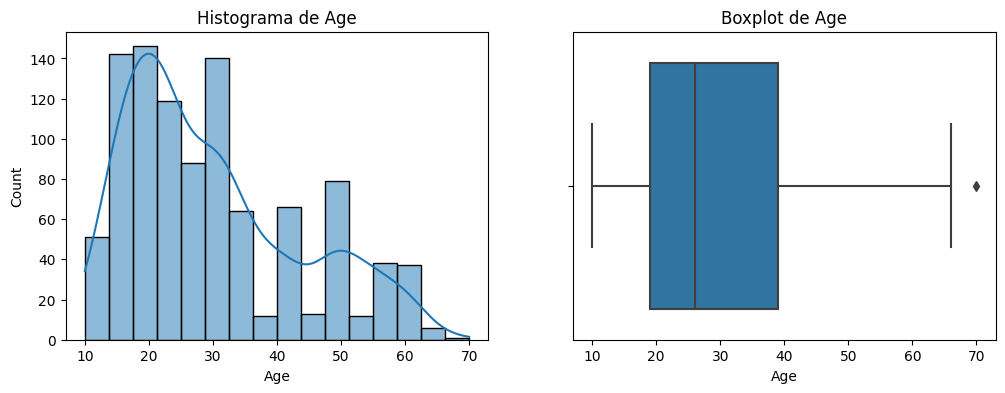

In [54]:
plot_hist_box(mhr_dataset_base, 'Age')

É possível observar que o atributo Age possui sua mediana em torno de 26 anos e que existem muitos exemplos entre os valores de 20 até 35 anos, enquanto valores maiores e menores que esse intervalo possuem poucos exemplos.

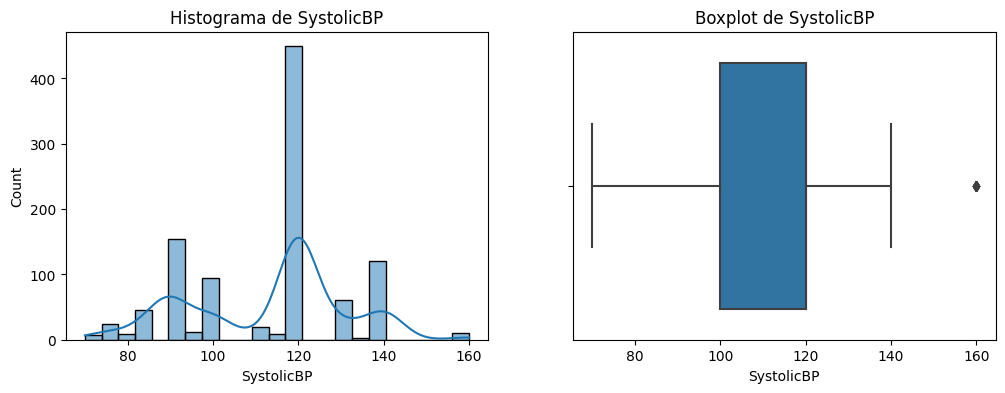

In [55]:
plot_hist_box(mhr_dataset_base, 'SystolicBP')

Ao examinar os gráficos acima, pode-se afirmar que a mediana do atributo SystolicBP é em torno de 120, com uma grande quantidade de exemplos na faixa de 100 até 120, além de verificar um pequeno grupo de exemplos entre os valores de 80 até 100, e entre 130 até 140. É também visível um *outlier* no valor 160.

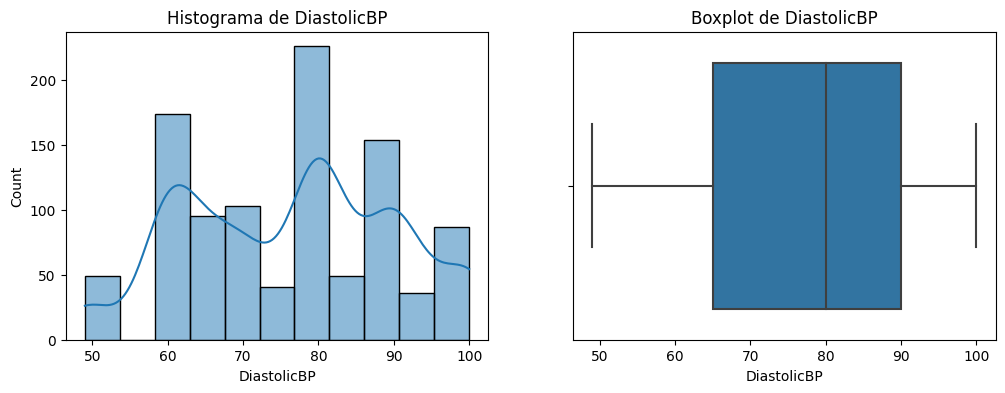

In [56]:
plot_hist_box(mhr_dataset_base, 'DiastolicBP')

O atributo DiastolicBP possui sua mediana em 80, com exemplos relativamente bem distribuídos, principalmente na faixa entre 65 e 90.

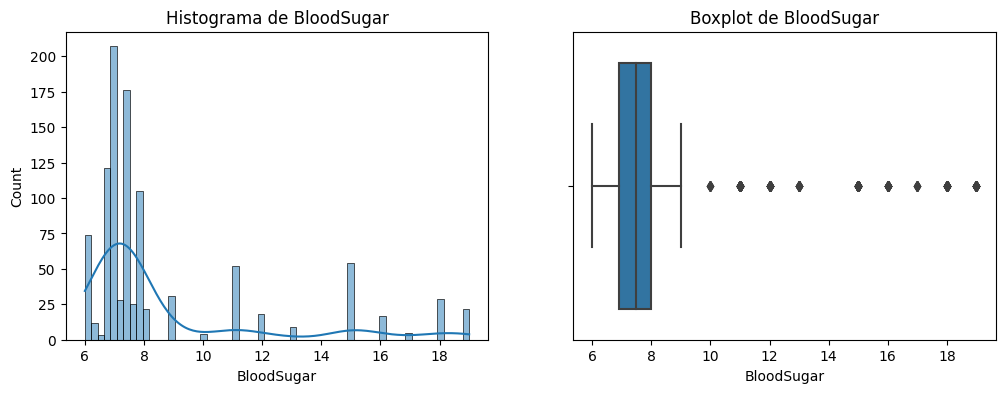

In [57]:
plot_hist_box(mhr_dataset_base, 'BloodSugar')

Diferente do atributo DiastolicBP, o atributo BloodSugar possui exemplos dispersos, com sua grande maioria entre os valores de 7 e 8, sua mediana é em torno de 7,5. É bastante visível os diversos *outliers* existentes neste atributo.

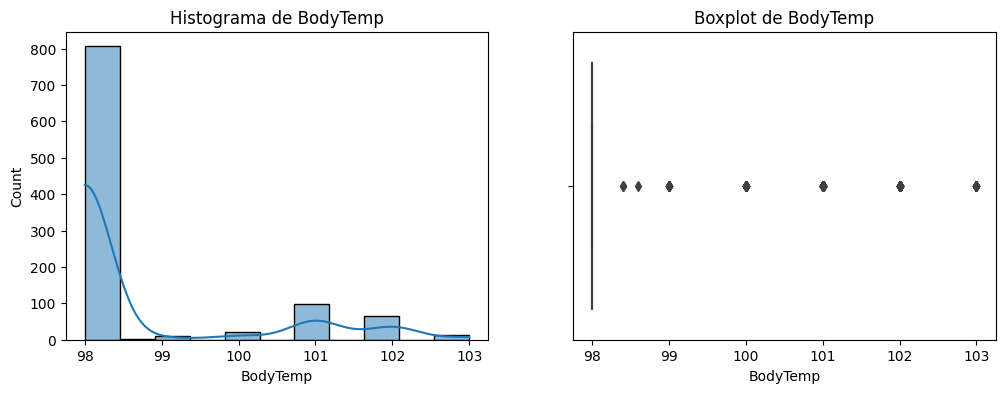

In [58]:
plot_hist_box(mhr_dataset_base, 'BodyTemp')

É notável a dispariedade dos valores dos exemplos do atributo BodyTemp, com sua mediana e a maioria dos exemplos com valor 98, e os outro valores sendo considerados quase *outliers*, apesar de estarem próximo do valor 98.

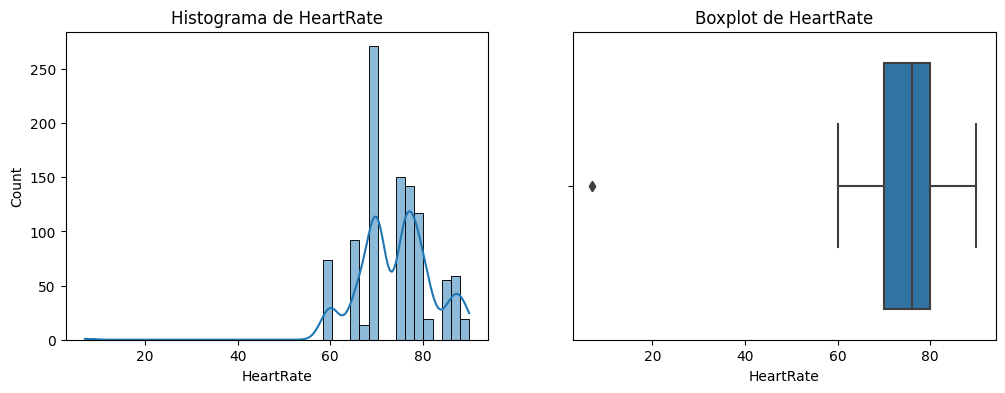

In [59]:
plot_hist_box(mhr_dataset_base, 'HeartRate')

Por último, o atributo HeartRate possui a maioria dos seus exemplos entre 70 e 80, e sua mediana é de aproximadamente 75. É possível obervar a existência de um *outlier* próximo do valor 10.

## Preparação dos dados

### Categorização dos dados

In [60]:
dummies = pd.get_dummies(mhr_dataset_base["RiskLevel"])
mhr_dataset_wo_risk_level = mhr_dataset_base.drop(["RiskLevel"], axis=1)

mhr_dataset_final = pd.concat([mhr_dataset_wo_risk_level, dummies], axis=1)
mhr_dataset_final.head()

,Age,SystolicBP,DiastolicBP,BloodSugar,BodyTemp,HeartRate,high risk,low risk,mid risk
0,25,130,80,15.0,98.0,86,1,0,0
1,35,140,90,13.0,98.0,70,1,0,0
2,29,90,70,8.0,100.0,80,1,0,0
3,30,140,85,7.0,98.0,70,1,0,0
4,35,120,60,6.1,98.0,76,0,1,0


## Separando a base de dados em atributos preditores e alvos

In [61]:
X = mhr_dataset_final.drop(columns=["high risk","low risk","mid risk"],axis=1)
y = mhr_dataset_final[["high risk","low risk","mid risk"]]

## Realizando a normalização dos dados

In [62]:
X_norm = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))

X_norm.head()

,Age,SystolicBP,DiastolicBP,BloodSugar,BodyTemp,HeartRate
0,0.250000,0.666667,0.607843,0.692308,0.0,0.951807
1,0.416667,0.777778,0.803922,0.538462,0.0,0.759036
2,0.316667,0.222222,0.411765,0.153846,0.4,0.879518
3,0.333333,0.777778,0.705882,0.076923,0.0,0.759036
4,0.416667,0.555556,0.215686,0.007692,0.0,0.831325
